# 1. Settings
## 1) import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyper parameters

In [12]:
batch_size = 64
learning_rate = 1e-4
epochs = 20

n_node = 1024
dropout_ratio = 0.5

img_size = 256

# Data Loader
### training data

In [13]:
covid_dir = './data'
covid_data = dset.ImageFolder(
    covid_dir,
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
)
print(len(covid_data))

21165


### split data into train, val, test set

In [14]:
N_COVID = len(covid_data)

# split data ratio train : val : test = 6 : 2 : 2 
N_TRAIN = (N_COVID // 10) * 6
N_VAL = (N_COVID - N_TRAIN) // 2
N_TEST = N_COVID - N_TRAIN - N_VAL

train_data, val_data, test_data = data.random_split(covid_data, (N_TRAIN, N_VAL, N_TEST))
print(f'train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}')

train: 12696, val: 4234, test: 4235


### Data Load onto dataloader

In [25]:
train_batch = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

val_batch = DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

test_batch = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

nclass = len(covid_data.classes)
print(f'# of classes: {nclass}')
print(covid_data.classes)
print(covid_data.class_to_idx)
print(len(covid_data))
print(f'Training: {len(train_data)}, val_data: {len(val_data)}, test_data: {len(test_data)}')

# print('\nclasses')
# print(train_data.classes)
# print(val_data.classes)
# print(test_data.classes)

# of classes: 4
['COVID', 'Lung_Opacity', 'Normal', 'Virtual_Pneumonia']
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Virtual_Pneumonia': 3}
21165
Training: 12696, val_data: 4234, test_data: 4235


# 3. Model
## 1) Pretrained VGG Model

In [17]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

print(list(vgg.children())[0][0])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [18]:
base_dim = 64
fsize = img_size // 32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(8 * base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),

            nn.Linear(n_node, nclass)
        )

        for m in self.layer1.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
#         print(x.shape)
        
        x = self.layer0(x)
        
#         print(x.shape)
        
        x = x.view(x.size(0), -1)
        x = self.layer1(x)

        return x

### 3) Model on GPU

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device : {device}')

model = MyVGG().to(device)

for params in model.layer0.parameters():
    params.requires_grad = False
for params in model.layer1.parameters():
    params.requires_grad = True

# for name in model.children():
#     print(name)

print(model)

device : cuda
MyVGG(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), strid

# 4. Optimizer & Loss

In [20]:
loss_func = nn.CrossEntropyLoss().to(device)
optimzer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# Train

3 layer, n_node, 1024, dropout_ratio: 0.50


  0%|          | 0/20 [00:00<?, ?it/s]

Correc of train: 13.75, val: 14.17, test: 13.36


 45%|████▌     | 9/20 [08:53<10:53, 59.44s/it]


[9 20] loss: 0.30125364661216736


 50%|█████     | 10/20 [11:30<14:54, 89.43s/it]

Correct of train: 99.86, val: 90.41, test: 91.05
Total time: 593.42


 95%|█████████▌| 19/20 [20:26<01:00, 60.72s/it]


[19 20] loss: 2.685402250790503e-05


100%|██████████| 20/20 [23:03<00:00, 69.16s/it]

Correct of train: 100.00, val: 90.72, test: 91.57
Total time: 1189.01


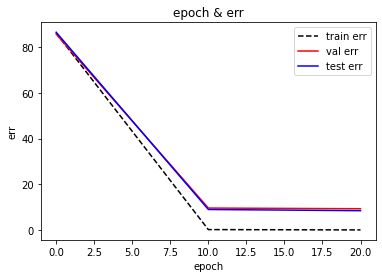

In [21]:
from tqdm import tqdm

total_time = 0
disp_step = 10

to_train = False
if to_train == False:
    netname = './nets/covid_vgg20_19.pkl'
    model = torch.load(netname)
    model.to(device)
else:
    print(f'3 layer, n_node, {n_node}, dropout_ratio: {dropout_ratio:.2f}')
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    val_corr = utils.ComputeCorr(val_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print(f'Correc of train: {train_corr:.2f}, val: {val_corr:.2f}, test: {test_corr:.2f}')
    model.train()

    net_name = './nets/covid_vgg20'

    # graph
    x_epoch = []
    y_train_err = []
    y_val_err = []
    y_test_err = []

    x_epoch.append(0)
    y_train_err.append(100.0 - train_corr)
    y_val_err.append(100.0 - val_corr)
    y_test_err.append(100.0 - test_corr)

    for i in tqdm(range(epochs)):
        start_time = time.time()
#         print(f'{i+1}..', end='')
        for img, label in train_batch:
            img = Variable(img).to(device)
            label = Variable(label).to(device)

            optimzer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimzer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration

        if (i+1) % disp_step == 0 or i == epochs-1:
            torch.save(model, net_name+f'_{i}.pkl')
            print(f'\n[{i} {epochs}] loss: {(loss.cpu()).data.numpy()}')
            
            model.eval()
            train_corr = utils.ComputeCorr(train_batch, model)
            val_corr = utils.ComputeCorr(val_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            
            print(f'Correct of train: {train_corr:.2f}, val: {val_corr:.2f}, test: {test_corr:.2f}')
            
            # draw graph
            x_epoch.append(i+1)
            y_train_err.append(100.0 - train_corr)
            y_val_err.append(100.0 - val_corr)
            y_test_err.append(100.0 - test_corr)
            
            print(f'Total time: {total_time:.2f}')
            
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_val_err, color='red', label='val err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err')
    plt.legend(loc='upper right')
    plt.show()

# 6. Evaluation for test & val data

Normalized confusion matrix


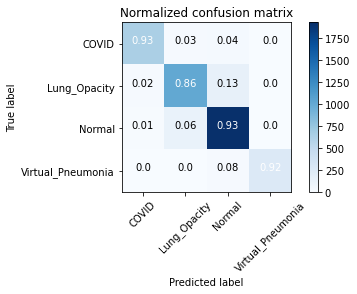

Confusion matrix, without normalization


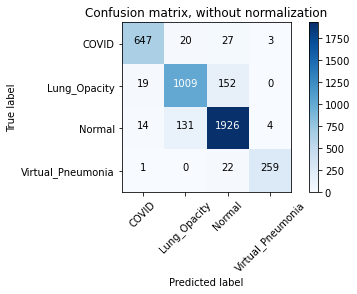

	 acc  |	 pre  |	 rec  |	 f1
 COVID: 0.98 |	 0.95 |	 0.93 |	 0.94
 Lung_Opacity: 0.91 |	 0.87 |	 0.86 |	 0.86
 Normal: 0.92 |	 0.91 |	 0.93 |	 0.92
 Virtual_Pneumonia: 0.99 |	 0.97 |	 0.92 |	 0.95
*accuracy: 0.95, precision: 0.92, recall: 0.91, *f1 score: 0.92
[AP]
COVID: 0.99
Lung_Opacity: 0.93
Normal: 0.97
Virtual_Pneumonia: 0.98

[mAP] 0.964
[miAP] 0.974


(array([1, 1, 1, ..., 0, 0, 2]),
 array([1, 0, 1, ..., 0, 0, 2]),
 array([0.99999934, 0.9954859 , 1.        , ..., 0.99984264, 0.62785089,
        0.76918334]))

In [23]:
model.eval()
utils.EvaluateClassifier(val_batch, model, covid_data.classes, batch_size)

Category: COVID
 True predicted images/total COVID category: 647 / 697
Predicted probability:
[1.0000000e+00 1.0102562e-10 4.0624626e-10 5.9167227e-09]


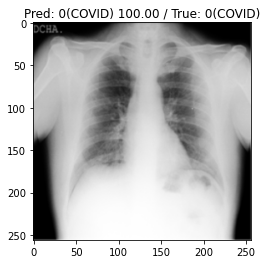

Predicted probability:
[9.9867415e-01 3.8319719e-08 1.3229548e-03 2.8267777e-06]


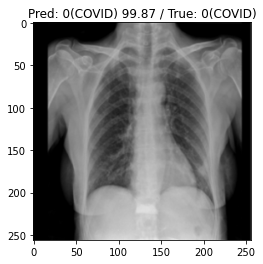

 False predicted images/total COVID category: 50 / 697
Predicted probability:
[4.5106877e-03 9.9548590e-01 2.6087337e-06 7.7903428e-07]


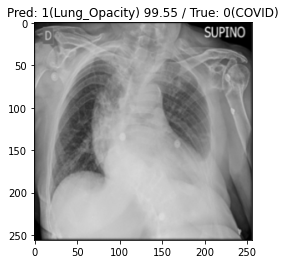

Predicted probability:
[1.6961748e-02 9.8303610e-01 1.5605384e-09 2.1556987e-06]


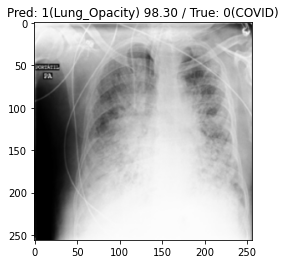

Category: Lung_Opacity
 True predicted images/total Lung_Opacity category: 1009 / 1180
Predicted probability:
[4.9695103e-07 9.9999934e-01 6.7432962e-11 1.3165349e-07]


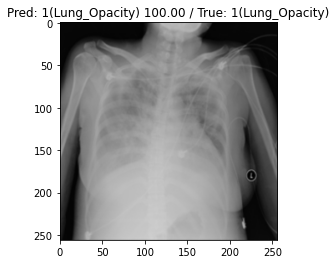

Predicted probability:
[3.68634394e-11 1.00000000e+00 1.19696041e-11 1.05024524e-10]


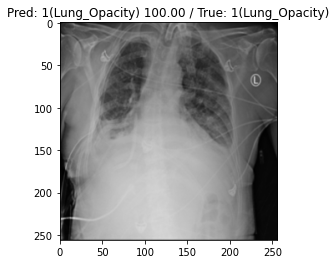

 False predicted images/total Lung_Opacity category: 171 / 1180
Predicted probability:
[1.8444247e-06 1.0927508e-01 8.9071697e-01 6.0815369e-06]


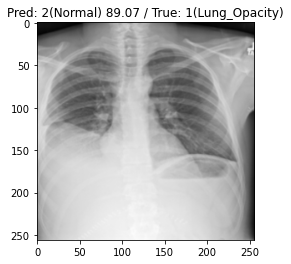

Predicted probability:
[2.7122053e-09 1.4423047e-02 9.8557687e-01 9.2744145e-08]


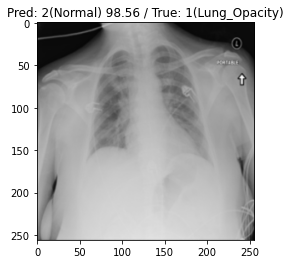

Category: Normal
 True predicted images/total Normal category: 1926 / 2075
Predicted probability:
[7.2918567e-08 5.7996192e-07 9.9999928e-01 8.0083815e-08]


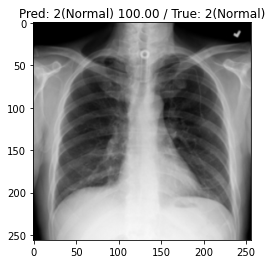

Predicted probability:
[1.0900067e-10 4.2576954e-07 9.9999958e-01 1.7275142e-09]


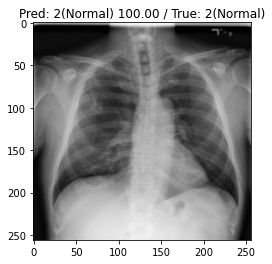

 False predicted images/total Normal category: 149 / 2075
Predicted probability:
[1.05994695e-05 9.99583900e-01 3.89242807e-04 1.62689539e-05]


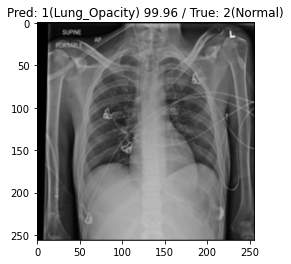

Predicted probability:
[1.9375955e-07 6.2033820e-01 3.7965620e-01 5.4071902e-06]


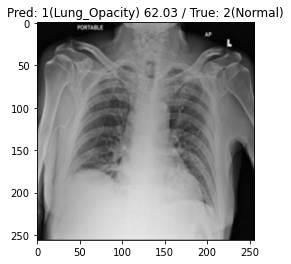

Category: Virtual_Pneumonia
 True predicted images/total Virtual_Pneumonia category: 259 / 282
Predicted probability:
[1.3703572e-09 4.4543361e-10 1.0659001e-09 1.0000000e+00]


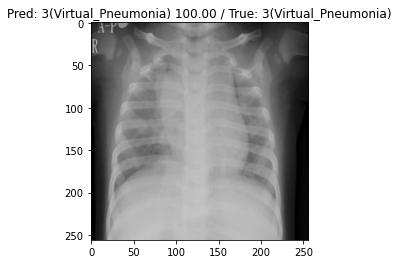

Predicted probability:
[8.7801366e-10 2.9008466e-11 1.5788808e-10 1.0000000e+00]


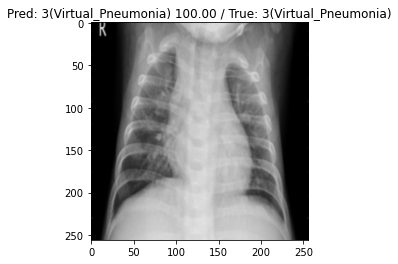

 False predicted images/total Virtual_Pneumonia category: 23 / 282
Predicted probability:
[3.5254999e-08 3.9414200e-08 9.9979907e-01 2.0083207e-04]


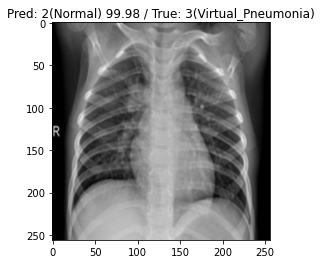

Predicted probability:
[6.5041682e-08 4.7651588e-06 8.5394299e-01 1.4605221e-01]


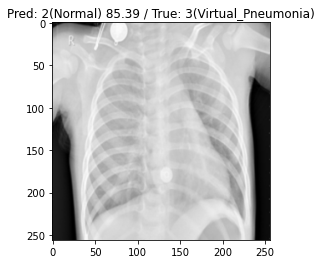

In [24]:
utils.VisTFPred(val_batch, model, covid_data.classes, batch_size, i_n=2)